# Spike count data regression

Here we fit the Universal Count Model to a synthetic spike count time series, generated by a simple tuning curve model of a ring bump attractor network representing head direction with various count output processes.

### Table of contents

1. [**Synthetic count data**](#syn)
    - [Heteroscedastic negative binomial](#syn_nb)
    - [Heteroscedastic Zero-inflated Poisson](#syn_zip)
    - [Heteroscedastic Conway-Maxwell-Poisson](#syn_cmp)
2. [**Model recovery**](#recover)
    - [Fitting within model class](#recover_fit)
    - [Posterior tuning curves](#recover_post)
3. [**Fitting the UCM**](#fitting)
4. [**Evaluating the UCM**](#eval)
    - [Goodness-of-fit metrics](#eval_fit)
    - [Computing spike count distributions](#eval_SCD)
    - [Inspecting model parameters](#eval_inspect)

In [23]:
import torch
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

import neuroprob as nprb
from neuroprob import utils
from neuroprob.likelihoods.discrete import gen_NB, gen_ZIP, gen_CMP


dev = nprb.inference.get_device()  # PyTorch device, gpu 0 by default if available

PyTorch version: 1.13.1+cu117
Using device: cuda:0


In [2]:
# useful colormap
white = '#ffffff'
red = '#ff0000'
blue = '#0000ff'
weight_map = utils.plots.make_cmap([blue, white, red], 'weight_map')

# seed everything
seed = 123
torch.manual_seed(seed)
rng = np.random.default_rng(seed)  # seed RNG

<a id="syn"></a>
## 1. Synthetic count data

Collect all data into a dictionary.

In [ ]:
datasets = {}

In [6]:
def HDC_bumps(theta, A, invbeta, b, theta_0):
    """
    parameters have shape (neurons,)
    :return:
        rates of shape (..., neurons, eval_pts)
    """
    return A[:, None] * np.exp(
        (np.cos(theta[..., None, :] - theta_0[:, None]) - 1) / invbeta[:, None]) + b[:, None]

In [11]:
timesamples = 10000
tbin = 0.05
neurons = 50


# random walk
hd_t = np.empty(timesamples)
hd_t[0] = 0
rn = rng.normal(size=(timesamples,))
for k in range(1, timesamples):
    hd_t[k] = hd_t[k-1] + 0.1*rn[k]
    
hd_t = hd_t % (2*np.pi)

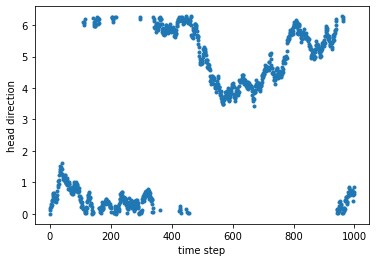

In [17]:
plt.figure()
plt.scatter(np.arange(T), hd_t[:T], marker='.')
plt.ylabel('head direction')
plt.xlabel('time step')
plt.show()

<a id="syn_nb"></a>
### 1.1 Heteroscedastic negative binomial counts

Here we generate synthetic data from a heteroscedastic negative binomial (NB) process with bump-like tuning curves for both the mean $\lambda$ and dispersion $r$ parameters as a function of head direction. Note the NB count distribution 

$$ P(n|\lambda, r) = $$

In [12]:
# von Mises fields
p_c = rng.normal(size=(neurons,))**2 + 1.0
p_a = np.maximum(0.0, 30.0 + 0.1*rng.normal(size=(neurons,)))
p_b = 0.2*rng.normal(size=(neurons,))**2 + 0.3
p_z = np.linspace(0, 2*np.pi, neurons+1)[:-1]

_angle_0 = rng.permutation(p_z)
_beta = (0.2 * rng.normal(size=(neurons,)))**2 + 0.01
_rate_0 = rng.uniform(size=(neurons,)) * 30.0
_b = rng.uniform(size=(neurons,)) * 1.

# rate tuning curve
vm_rate = lambda x: HDC_bumps(x, p_a, p_b, p_c, p_z)

# dispersion tuning curve
vm_disp = lambda x: HDC_bumps(x, _rate_0, 1./_beta, _b, _angle_0)

In [13]:
steps = 1000
show_neurons = [0, 1, 2]
covariates = np.linspace(0, 2*np.pi, steps)

rate = vm_rate(covariates)
r = vm_disp(covariates)

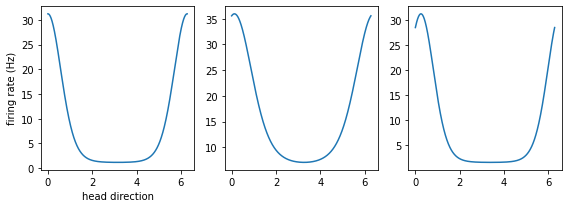

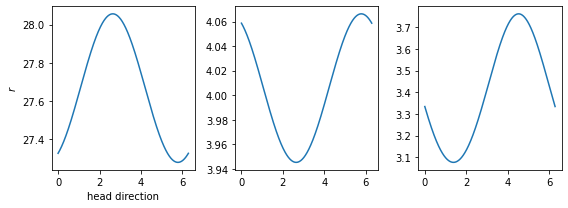

In [14]:
fig, axes = plt.subplots(1, len(show_neurons), figsize=(8, 3))

for k, ne in enumerate(show_neurons):
    line, = axes[k].plot(covariates, rate[ne, :])
    if k == 0:
        axes[k].set_xlabel('head direction')
        axes[k].set_ylabel('firing rate (Hz)')
    
fig.tight_layout()
plt.show()


fig, axes = plt.subplots(1, len(show_neurons), figsize=(8, 3))

for k, ne in enumerate(show_neurons):
    line, = axes[k].plot(covariates, r[ne, :])
    if k == 0:
        axes[k].set_xlabel('head direction')
        axes[k].set_ylabel(r'$r$')
    
fig.tight_layout()
plt.show()

In [15]:
# generate data
rate_t = vm_rate(hd_t)
r_t = vm_disp(hd_t)

syn_train = gen_NB(rng, rate_t*tbin, r_t)
datasets["hNB"] = syn_train

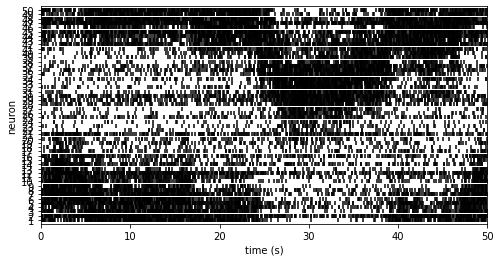

In [16]:
T = 1000

fig, ax = plt.subplots(figsize=(8,4))

utils.plots.raster_plot((fig, ax), syn_train[:, :T], T, tbin, neurons, markersize=10)
ax.set_xlabel('time (s)')
ax.set_ylabel('neuron')

plt.show()

<a id="syn_zip"></a>
### 1.2 Heteroscedastic Zero-inflated Poisson counts

Here we generate synthetic data from a heteroscedastic Zero-inflated Poisson (ZIP) process with bump-like tuning curves for both the mean $\lambda$ and dispersion $\alpha$ parameters as a function of head direction. Note the ZIP count distribution 

$$ P(n|\lambda, \alpha) = $$

In [24]:
# von Mises fields
p_c = rng.normal(size=(neurons,))**2 + 1.0
p_a = np.maximum(0.0, 30.0 + 0.1*rng.normal(size=(neurons,)))
p_b = 0.2*rng.normal(size=(neurons,))**2 + 0.3
p_z = np.linspace(0, 2*np.pi, neurons+1)[:-1]

_angle_0 = rng.permutation(p_z)
_beta = (0.5 * rng.normal(size=(neurons,)))**2 + 0.1
_rate_0 = rng.uniform(size=(neurons,)) * 2.0 - 4.
_b = rng.uniform(size=(neurons,)) * 3.

# rate tuning curve
vm_rate = lambda x: HDC_bumps(x, p_a, p_b, p_c, p_z)

# dispersion tuning curve
vm_disp = lambda x: 1. / (1 + np.exp(-HDC_bumps(x, _rate_0, 1./_beta, _b, _angle_0)))

In [25]:
steps = 1000
show_neurons = [0, 1, 2]
covariates = np.linspace(0, 2*np.pi, steps)

rate = vm_rate(covariates)
alpha = vm_disp(covariates)

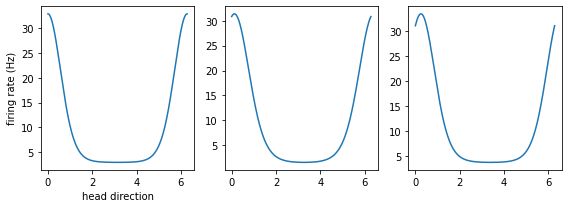

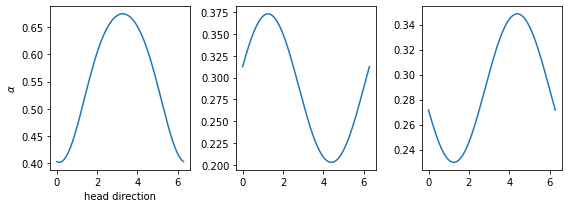

In [26]:
fig, axes = plt.subplots(1, len(show_neurons), figsize=(8, 3))

for k, ne in enumerate(show_neurons):
    line, = axes[k].plot(covariates, rate[ne, :])
    if k == 0:
        axes[k].set_xlabel('head direction')
        axes[k].set_ylabel('firing rate (Hz)')
    
fig.tight_layout()
plt.show()


fig, axes = plt.subplots(1, len(show_neurons), figsize=(8, 3))

for k, ne in enumerate(show_neurons):
    line, = axes[k].plot(covariates, alpha[ne, :])
    if k == 0:
        axes[k].set_xlabel('head direction')
        axes[k].set_ylabel(r'$\alpha$')
    
fig.tight_layout()
plt.show()

In [27]:
# generate data
rate_t = vm_rate(hd_t)
alpha_t = vm_disp(hd_t)

syn_train = gen_ZIP(rng, rate_t*tbin, alpha_t)
datasets["hZIP"] = syn_train

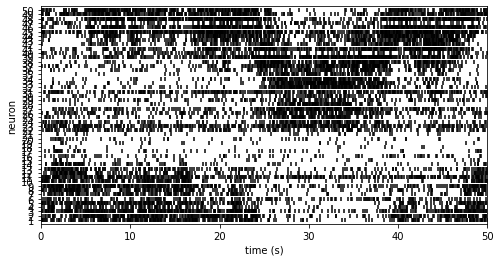

In [28]:
T = 1000

fig, ax = plt.subplots(figsize=(8,4))

utils.plots.raster_plot((fig, ax), syn_train[:, :T], T, tbin, neurons, markersize=10)
ax.set_xlabel('time (s)')
ax.set_ylabel('neuron')

plt.show()

<a id="syn_cmp"></a>
### 1.3 Heteroscedastic Conway-Maxwell-Poisson counts

Here we generate synthetic data from a heteroscedastic Conway-Maxwell-Poisson (CMP) process with bump-like tuning curves for both the mean $\lambda$ and dispersion $\nu$ parameters as a function of head direction. Note the ZIP count distribution 

$$ P(n|\lambda, \nu) = $$

In [38]:
# von Mises fields
p_c = rng.normal(size=(neurons,))**2 + 1.0
p_a = np.maximum(0.0, 30.0 + 0.1*rng.normal(size=(neurons,)))
p_b = 0.2*rng.normal(size=(neurons,))**2 + 0.3
p_z = np.linspace(0, 2*np.pi, neurons+1)[:-1]

_angle_0 = rng.permutation(p_z)
_beta = (0.5 * rng.normal(size=(neurons,)))**2 + 0.1
_rate_0 = rng.uniform(size=(neurons,)) * 1.0 - 4.
_b = rng.uniform(size=(neurons,)) * 1. - 1.

# rate tuning curve
vm_rate = lambda x: HDC_bumps(x, p_a, p_b, p_c, p_z)

# dispersion tuning curve
vm_disp = lambda x: 1. / (1 + np.exp(-HDC_bumps(x, _rate_0, 1./_beta, _b, _angle_0)))

In [39]:
steps = 1000
show_neurons = [0, 1, 2]
covariates = np.linspace(0, 2*np.pi, steps)

rate = vm_rate(covariates)
nu = vm_disp(covariates)

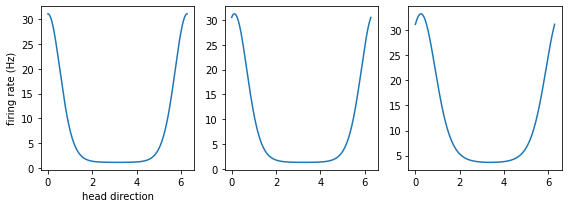

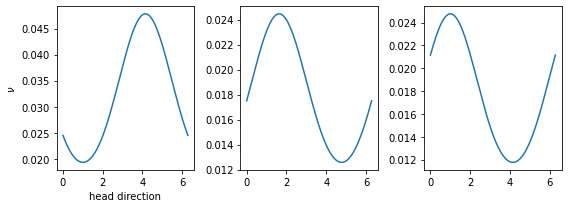

In [40]:
fig, axes = plt.subplots(1, len(show_neurons), figsize=(8, 3))

for k, ne in enumerate(show_neurons):
    line, = axes[k].plot(covariates, rate[ne, :])
    if k == 0:
        axes[k].set_xlabel('head direction')
        axes[k].set_ylabel('firing rate (Hz)')
    
fig.tight_layout()
plt.show()


fig, axes = plt.subplots(1, len(show_neurons), figsize=(8, 3))

for k, ne in enumerate(show_neurons):
    line, = axes[k].plot(covariates, nu[ne, :])
    if k == 0:
        axes[k].set_xlabel('head direction')
        axes[k].set_ylabel(r'$\nu$')
    
fig.tight_layout()
plt.show()

In [41]:
# generate data
rate_t = vm_rate(hd_t)
nu_t = vm_disp(hd_t)

syn_train = gen_CMP(rng, rate_t*tbin, nu_t)
datasets["hCMP"] = syn_train

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

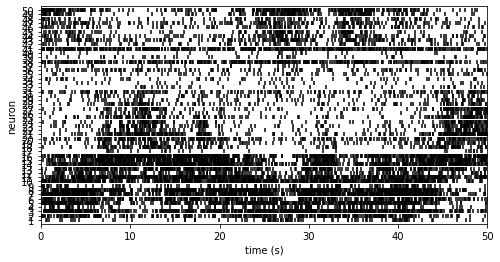

In [9]:
T = 1000

fig, ax = plt.subplots(figsize=(8,4))

utils.plots.raster_plot((fig, ax), syn_train[:, :T], T, tbin, neurons, markersize=10)
ax.set_xlabel('time (s)')
ax.set_ylabel('neuron')

plt.show()

<a id="recover"></a>
## 2. Model recovery


<a id='recover_fit'></a>
### 2.1 Fitting within model class

In [42]:
batch_size = 1000
out_dims = neurons

gp_models = {}
for name in datasets.keys():
    modules = []
    for _ in range(2):
        # kernel
        l = 2.*torch.ones(1, out_dims)
        v = 1.*torch.ones(out_dims)

        krn_1 = nprb.kernels.Constant(variance=v, tensor_type=torch.float)
        krn_2 = nprb.kernels.SquaredExponential(
            input_dims=len(l), lengthscale=l, \
            track_dims=[0], topology='ring', f='softplus', \
            tensor_type=torch.float
        )

        kernel = nprb.kernels.Product(krn_1, krn_2)

        # inputs
        input_data = [torch.from_numpy(hd_t)]
        input_group = nprb.inputs.input_group()
        input_group.set_XZ(input_data, timesamples, batch_info=batch_size)

        # inducing points
        num_induc = 3
        Xu = np.array(
            [np.linspace(0, 2*np.pi, num_induc+1)[:-1]]
        ).T[None, ...].repeat(out_dims, axis=0)
        inducing_points = nprb.mappings.inducing_points(
            out_dims, torch.from_numpy(Xu), jitter=1e-5)

        # mapping
        in_dims = Xu.shape[-1]

        modules.append(
            nprb.mappings.SVGP(
                in_dims, neurons, kernel, inducing_points=inducing_points, 
                whiten=True, jitter=1e-4, mean=torch.zeros(neurons), learn_mean=True
            )
        )

    rate_gp, disp_gp = modules

    # likelihood
    if name == "hNB":
        likelihood = nprb.likelihoods.discrete.hNegative_binomial(tbin, neurons, 'exp', disp_gp)
    elif name == "hZIP":
        likelihood = nprb.likelihoods.discrete.hZI_Poisson(tbin, neurons, 'exp', disp_gp)
    elif name == "hCMP":
        likelihood = nprb.likelihoods.discrete.hCOM_Poisson(tbin, neurons, 'exp', disp_gp)
    
    likelihood.set_Y(torch.from_numpy(syn_train), batch_info=batch_size) 

    # assemble
    gpr = nprb.inference.VI_optimized(input_group, rate_gp, likelihood)
    gp_models[name] = gpr
    
#gpr.to(dev)

NameError: name 'datasets' is not defined

In [12]:
# fitting
sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.95)
opt_lr_dict = {
    'default': 1e-2, 
}

gpr.set_optimizers(optim.Adam, sch, 100, opt_lr_dict)

annealing = lambda x: 1.0
losses = gpr.fit(1000, loss_margin=-1e1, margin_epochs=30, kl_anneal_func=annealing, 
                 cov_samples=1, ll_samples=10, ll_mode='MC')

  0%|          | 0/1000 [00:00<?, ?it/s]


Stopped at epoch 719.


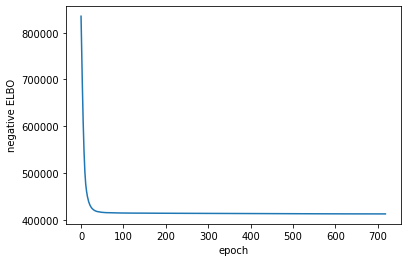

In [13]:
plt.figure()
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('negative ELBO')
plt.show()

<a id='recover_post'></a>
### 2.2 Posterior tuning curves

In [14]:
def smooth_percentiles(perc, smooth_length):  # smooth the samples
    sw = np.ones(smooth_length) / smooth_length
    return utils.stats.smooth_histogram(perc, sw, ['periodic'])

In [15]:
# tuning curves
steps= 100
show_neurons = [0, 1, 10]
covariates = np.linspace(0, 2*np.pi, steps)[None, :]  # (dims, timesteps)
MC = 1000

with torch.no_grad():
    samples = utils.model.marginal_posterior_samples(
        rate_gp, likelihood.f, torch.from_numpy(covariates), MC, show_neurons)
    
lower, median, upper = [
    smooth_percentiles(p.cpu().numpy(), smooth_length=5)
    for p in utils.stats.percentiles_from_samples(samples)
]  # rate function

with torch.no_grad():
    samples = utils.model.marginal_posterior_samples(
        disp_gp, likelihood.dispersion_mapping_f, torch.from_numpy(covariates), MC, show_neurons)

dlower, dmedian, dupper = [
    smooth_percentiles(p.cpu().numpy(), smooth_length=5)
    for p in utils.stats.percentiles_from_samples(samples)
]  # dispersion function

# ground truth
rate = vm_rate(covariates[0])
r = vm_disp(covariates[0])

# ground truth
rate = vm_rate(covariates[0])
alpha = vm_disp(covariates[0])

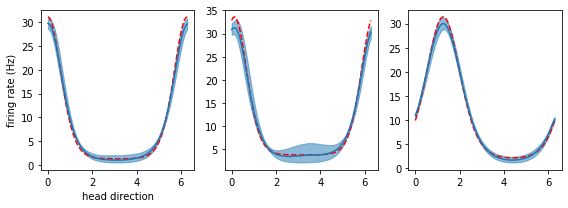

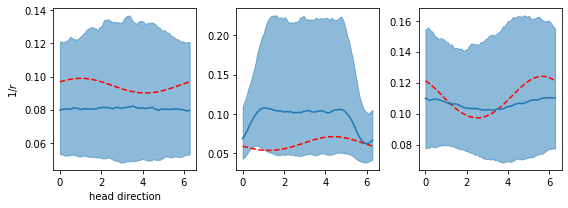

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3))

for k, n in enumerate(show_neurons):
    
    axes[k].plot(covariates[0], rate[n], 'r--')
    line, = axes[k].plot(covariates[0], median[k])
    axes[k].fill_between(
        covariates[0], lower[k],
        upper[k], color=line.get_color(), alpha=0.5
    )
    if k == 0:
        axes[k].set_xlabel('head direction')
        axes[k].set_ylabel('firing rate (Hz)')

fig.tight_layout()
plt.show()



fig, axes = plt.subplots(1, 3, figsize=(8, 3))

for k, n in enumerate(show_neurons):
    
    axes[k].plot(covariates[0], 1/r[n], 'r--')
    line, = axes[k].plot(covariates[0], dmedian[k])
    axes[k].fill_between(
        covariates[0], dlower[k],
        dupper[k], color=line.get_color(), alpha=0.5
    )
    if k == 0:
        axes[k].set_xlabel('head direction')
        axes[k].set_ylabel(r'$1/r$')

fig.tight_layout()
plt.show()

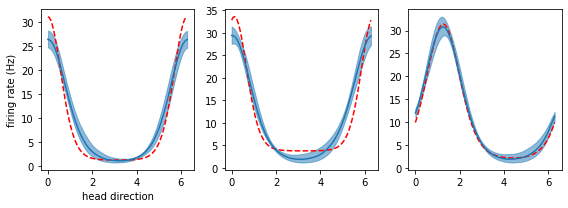

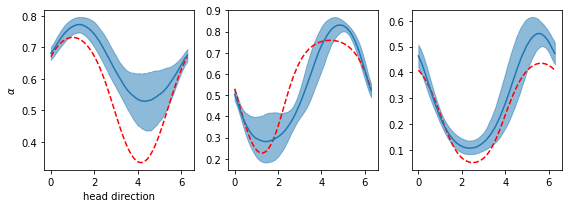

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3))

for k, n in enumerate(show_neurons):
    
    axes[k].plot(covariates[0], rate[n], 'r--')
    line, = axes[k].plot(covariates[0], median[k])
    axes[k].fill_between(
        covariates[0], lower[k],
        upper[k], color=line.get_color(), alpha=0.5
    )
    if k == 0:
        axes[k].set_xlabel('head direction')
        axes[k].set_ylabel('firing rate (Hz)')

fig.tight_layout()
plt.show()



fig, axes = plt.subplots(1, 3, figsize=(8, 3))

for k, n in enumerate(show_neurons):
    
    axes[k].plot(covariates[0], alpha[n], 'r--')
    line, = axes[k].plot(covariates[0], dmedian[k])
    axes[k].fill_between(
        covariates[0], dlower[k],
        dupper[k], color=line.get_color(), alpha=0.5
    )
    if k == 0:
        axes[k].set_xlabel('head direction')
        axes[k].set_ylabel(r'$\alpha$')

fig.tight_layout()
plt.show()

<a id="fitting"></a>
## 3. Building and fitting the UCM

We build and fit the Universal Count Model using the exponential-linear basis expansion with $C = 3$.

In [17]:
batch_size = 1000
C = 3
out_dims = C*neurons

# kernel
l = 5.*torch.ones(1, out_dims)
v = torch.ones(out_dims)

krn_1 = nprb.kernels.Constant(variance=v, tensor_type=torch.float)
krn_2 = nprb.kernels.SquaredExponential(
    input_dims=len(l), lengthscale=l, \
    track_dims=[0], topology='ring', f='softplus', \
    tensor_type=torch.float
)

kernel = nprb.kernels.Product(krn_1, krn_2)

# inputs
input_data = [torch.from_numpy(hd_t)]
input_group = nprb.inputs.input_group()
input_group.set_XZ(input_data, timesamples, batch_info=batch_size)

# inducing points
num_induc = 8
Xu = np.array(
    [np.linspace(0, 2*np.pi, num_induc+1)[:-1]]
).T[None, ...].repeat(out_dims, axis=0)
inducing_points = nprb.mappings.inducing_points(out_dims, torch.from_numpy(Xu))


# mapping
in_dims = Xu.shape[-1]

gp = nprb.mappings.SVGP(
    in_dims, out_dims, kernel, inducing_points=inducing_points, 
    whiten=True, jitter=1e-4, mean=torch.zeros(out_dims), learn_mean=True
)

# likelihood
basis_mode = 'el'  # exponential-linear
max_count = int(syn_train.max())
likelihood = nprb.likelihoods.discrete.Universal(neurons, C, basis_mode, 'identity', max_count)
likelihood.set_Y(torch.from_numpy(syn_train), batch_info=batch_size) 

# assemble
gpr = nprb.inference.VI_optimized(input_group, gp, likelihood)
gpr.to(dev)

VI_optimized(
  (input_group): input_group()
  (mapping): SVGP(
    (kernel): Product(
      (kern0): Constant()
      (kern1): SquaredExponential()
    )
    (induc_pts): inducing_points()
  )
  (likelihood): Universal(
    (lsoftm): LogSoftmax(dim=-1)
    (mapping_net): Parallel_Linear(in_features=6, out_features=19, channels=50, bias=True)
  )
)

In [18]:
# fitting
sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.95)
opt_lr_dict = {
    'default': 1e-2, 
}

gpr.set_optimizers(optim.Adam, sch, 100, opt_lr_dict)

annealing = lambda x: 1.0
losses = gpr.fit(3000, loss_margin=-1e0, margin_epochs=30, kl_anneal_func=annealing, 
                 cov_samples=1, ll_samples=10, ll_mode='MC')

  0%|          | 0/3000 [00:00<?, ?it/s]


Stopped at epoch 953.


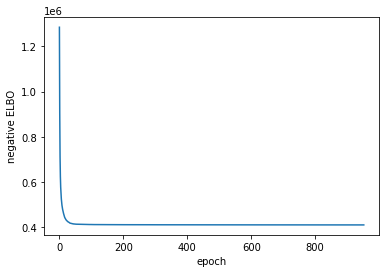

In [19]:
plt.figure()
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('negative ELBO')
plt.show()

<a id='eval'></a>
## 4. Evaluating the UCM

<a id='eval_fit'></a>
### 4.1 Goodness-of-fit metrics

As there is no trial structure, we cannot trivially obtain empirical count distributions from the data to compare with the estimated count distributions from the UCM. Apart from the likelihood score, a more direct measure of goodness-of-fit is given by the [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) adapted to count distributions. We compute the predictive spike count distribution given input covariates and then compute the quantiles of the observed spike counts. These are obtained from the training data, and will thus show us how well the model was able to fit in an absolute sense. We can turn these into $Z$-scores (which will be unit normal distributed if the model describes observations well).

In [20]:
# quantiles, Z scores
P_ = []
for b in range(gpr.input_group.batches):
    covariates, _ = gpr.input_group.sample_XZ(b, samples=1)  # get the training batch b
    with torch.no_grad():
        P_mc = utils.model.compute_UCM_P_count(
            gp, likelihood, covariates, list(range(neurons)), MC=30, trials=1)  # predictive posterior
    P_.append(P_mc.mean(0).cpu().numpy())  # take mean over MC samples
P = np.concatenate(P_, axis=1)  # count probabilities of shape (neurons, timesteps, count)


q = []
Z = []
trial = 0
for n in range(neurons):
    spike_binned = gpr.likelihood.Y[trial, n, :].numpy()
    q_ = utils.stats.counts_to_quantiles(P[n, ...], spike_binned, rng)
    q.append(q_)

q = np.array(q)  # quantiles of shape (neurons, timesteps)

We can obtain the Kolmogorov-Smirnov test statistic $T_{KS}$, and the dispersion statistic $T_{DS}$ as well (see paper). These statistics are computed per neuron and reflect single neuron goodness-of-fit measures. The $T_{KS}$ statistic seems to be roughly distributed as the sampling distribution under the null model, i.e. if the model generated the data this would be the distribution of $T_{KS}$ observed for an infinite number of repetitions of random data draws.

In [21]:
T_DS_bn = []
T_KS_bn = []
for qq in q:
    T_DS, T_KS, sign_DS, sign_KS, p_DS, p_KS = utils.stats.KS_DS_statistics(
        qq, alpha=0.05)
    T_DS_bn.append(T_DS)
    T_KS_bn.append(T_KS)

T_DS_bn = np.array(T_DS_bn)  # (neurons,)
T_KS_bn = np.array(T_KS_bn)


x = np.linspace(0, 0.02, 100)
bins = np.linspace(0, 0.02, 50)
f = utils.stats.KS_sampling_dist(x, len(q[0]))

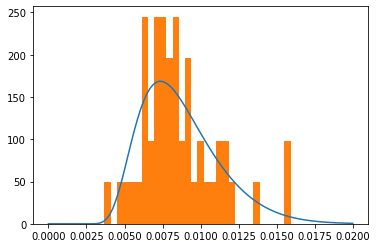

In [22]:
plt.plot(x, f)
plt.hist(T_KS_bn, bins=bins, density=True)
plt.show()

<a id='eval_SCD'></a>
### 4.2 Computing spike count distributions

We can compute the spike count distribution conditioned on input covariates, and in this way we can explore the neural tuning over a slice through input space. We set all other covariates at the mean values of the observed time series in the dataset.

In [23]:
hd_sweep = np.linspace(0, 2*np.pi, 100)
covariates = torch.from_numpy(hd_sweep)[None, None, :, None]  # (tr, neurons, steps, covariate dims)

with torch.no_grad():
    P_mc = utils.model.compute_UCM_P_count(
        gp, likelihood, covariates, list(range(neurons)), MC=30, trials=1)  # predictive posterior

P_mc = P_mc.cpu()  # count probabilities of shape (MC, neurons, steps, count)
lower, median, upper = utils.stats.percentiles_from_samples(P_mc, [0.05, 0.5, 0.95])


# true parameters
rate = vm_rate(hd_sweep)
r = vm_disp(hd_sweep)


# true parameters
rate = vm_rate(hd_sweep)
alpha = vm_disp(hd_sweep)

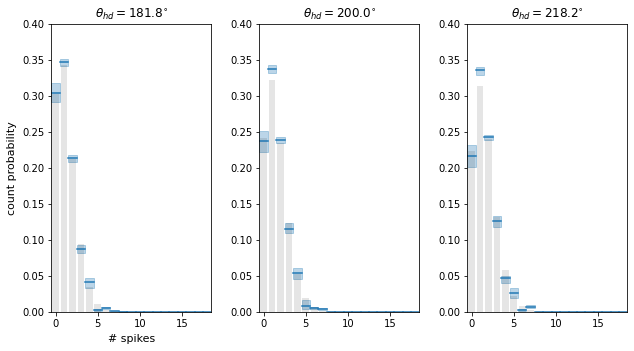

In [24]:
ne = 30  # select neuron to plot


fig = plt.figure(figsize=(8, 4))
widths = [1, 1, 1]
heights = [1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1., bottom=0.0, 
                        left=0., right=1., wspace=0.3)

for en, step_ind in enumerate([50, 55, 60]):
    ax = fig.add_subplot(spec[0, en])
    hd = hd_sweep[step_ind]
    
    # true count distribution
    bins = np.arange(max_count+1)
    gt_P = utils.stats.nb_count_prob(
        bins, rate[ne, step_ind], 1/r[ne, step_ind], tbin)
    
    ax.set_title(r'$\theta_{hd} = $' + '{:.1f}'.format(hd / np.pi * 180) + r'$^{\circ}$')
    for k in range(max_count+1):
        XX_ = np.linspace(k-0.5, k+0.5, 2)
        YY_ = np.ones(2) * median.numpy()[ne, step_ind, k]
        YY_l = np.ones(2) * lower.numpy()[ne, step_ind, k]
        YY_u = np.ones(2) * upper.numpy()[ne, step_ind, k]
        line, = ax.plot(XX_, YY_, c='tab:blue', alpha=1.)
        ax.fill_between(XX_, YY_l, 
            YY_u, color=line.get_color(), alpha=0.3, label='UCM' if k == 0 else None)
        
        ax.bar(XX_[0]+0.5, gt_P[k], color='k', alpha=0.1, label='truth' if k == 0 else None)


    ax.set_xlim([-0.5, max_count+.5])
    ax.set_ylim(0.0, 0.4)
    ax.set_xticks(np.arange(max_count+1)[::5])
    
    if en == 0:
        ax.set_ylabel('count probability', fontsize=11, labelpad=5)
        ax.set_xlabel('# spikes', labelpad=5, fontsize=11)
        
    if en == 2:
        ax.legend()

plt.show()

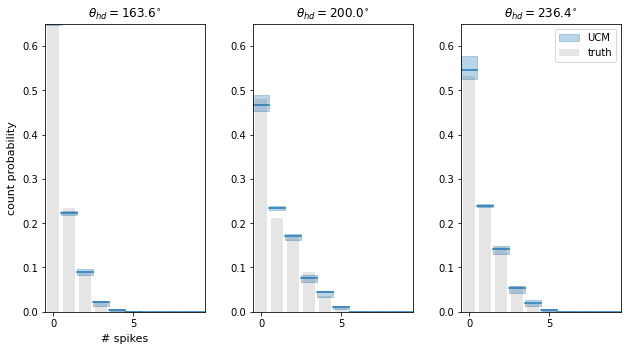

In [24]:
ne = 29  # select neuron to plot


fig = plt.figure(figsize=(8, 4))
widths = [1, 1, 1]
heights = [1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1., bottom=0.0, 
                        left=0., right=1., wspace=0.3)

for en, step_ind in enumerate([45, 55, 65]):
    ax = fig.add_subplot(spec[0, en])
    hd = hd_sweep[step_ind]
    
    # true count distribution
    bins = np.arange(max_count+1)
    gt_P = utils.stats.zip_count_prob(
        bins, rate[ne, step_ind], alpha[ne, step_ind], tbin)
    
    ax.set_title(r'$\theta_{hd} = $' + '{:.1f}'.format(hd / np.pi * 180) + r'$^{\circ}$')
    for k in range(max_count+1):
        XX_ = np.linspace(k-0.5, k+0.5, 2)
        YY_ = np.ones(2) * median.numpy()[ne, step_ind, k]
        YY_l = np.ones(2) * lower.numpy()[ne, step_ind, k]
        YY_u = np.ones(2) * upper.numpy()[ne, step_ind, k]
        line, = ax.plot(XX_, YY_, c='tab:blue', alpha=1.)
        ax.fill_between(XX_, YY_l, 
            YY_u, color=line.get_color(), alpha=0.3, label='UCM' if k == 0 else None)
        
        ax.bar(XX_[0]+0.5, gt_P[k], color='k', alpha=0.1, label='truth' if k == 0 else None)


    ax.set_xlim([-0.5, max_count+.5])
    ax.set_ylim(0.0, 0.65)
    ax.set_xticks(np.arange(max_count+1)[::5])
    
    if en == 0:
        ax.set_ylabel('count probability', fontsize=11, labelpad=5)
        ax.set_xlabel('# spikes', labelpad=5, fontsize=11)
        
    if en == 2:
        ax.legend()

plt.show()

Conventional tuning curves show mean firing rate as a function of some covariate. We can plot those by computing the mean of the count distribution.

In [25]:
counts = torch.arange(P.shape[-1])

hd_mean = (counts[None, None, None, :] * P_mc).sum(-1)  # (MC, neurons, steps)
hd_rate = hd_mean / tbin  # in units of Hz
hd_var = (counts[None, None, None, :]**2 * P_mc).sum(-1) - hd_mean**2
hd_FF = hd_var / (hd_mean + 1e-12)

lower, median, upper = [
    smooth_percentiles(p.cpu().numpy(), smooth_length=5)
    for p in utils.stats.percentiles_from_samples(hd_rate, [0.05, 0.5, 0.95])
]
flower, fmedian, fupper = [
    smooth_percentiles(p.cpu().numpy(), smooth_length=5)
    for p in utils.stats.percentiles_from_samples(hd_FF, [0.05, 0.5, 0.95])
]

# true tuning
gt_rate = rate
gt_FF = 1 + rate * tbin / r

# true tuning
gt_rate = (1 - alpha) * rate
gt_FF = (1 + rate * tbin * alpha)

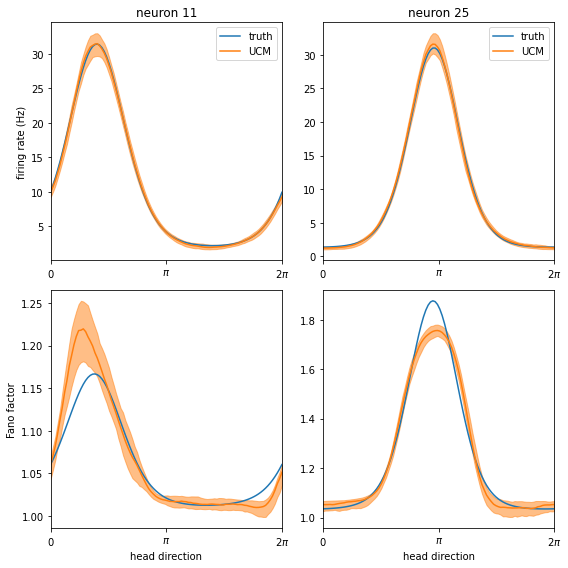

In [26]:
nes = [10, 24]  # select neuron to plot


fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for k, ne in enumerate(nes):
    axes[0, k].plot(hd_sweep, gt_rate[ne], label='truth')
    line, = axes[0, k].plot(hd_sweep, median[ne, :], label='UCM')
    axes[0, k].fill_between(
        hd_sweep, lower[ne, :], upper[ne, :], 
        color=line.get_color(), alpha=0.5
    )
    if k == 0:
        axes[0, k].set_ylabel('firing rate (Hz)')
    axes[0, k].set_xlim(0, 2*np.pi)
    axes[0, k].set_xticks([0, np.pi, 2*np.pi])
    axes[0, k].set_xticklabels([r'$0$', r'$\pi$', r'$2\pi$'])
    axes[0, k].legend()
    axes[0, k].set_title('neuron {}'.format(ne+1))

    axes[1, k].plot(hd_sweep, gt_FF[ne])
    line, = axes[1, k].plot(hd_sweep, fmedian[ne, :])
    axes[1, k].fill_between(
        hd_sweep, flower[ne, :], fupper[ne, :], 
        color=line.get_color(), alpha=0.5
    )
    if k == 0:
        axes[1, k].set_ylabel('Fano factor')
    axes[1, k].set_xlabel('head direction')
    axes[1, k].set_xlim(0, 2*np.pi)
    axes[1, k].set_xticks([0, np.pi, 2*np.pi])
    axes[1, k].set_xticklabels([r'$0$', r'$\pi$', r'$2\pi$'])

fig.tight_layout()
plt.show()

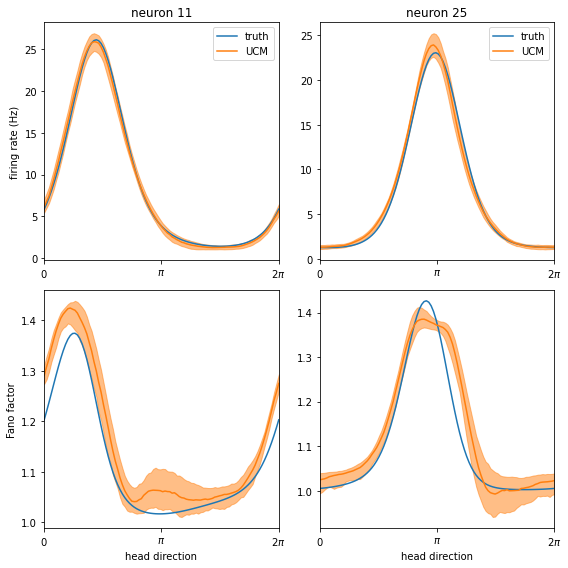

In [26]:
nes = [10, 24]  # select neuron to plot


fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for k, ne in enumerate(nes):
    axes[0, k].plot(hd_sweep, gt_rate[ne], label='truth')
    line, = axes[0, k].plot(hd_sweep, median[ne, :], label='UCM')
    axes[0, k].fill_between(
        hd_sweep, lower[ne, :], upper[ne, :], 
        color=line.get_color(), alpha=0.5
    )
    if k == 0:
        axes[0, k].set_ylabel('firing rate (Hz)')
    axes[0, k].set_xlim(0, 2*np.pi)
    axes[0, k].set_xticks([0, np.pi, 2*np.pi])
    axes[0, k].set_xticklabels([r'$0$', r'$\pi$', r'$2\pi$'])
    axes[0, k].legend()
    axes[0, k].set_title('neuron {}'.format(ne+1))

    axes[1, k].plot(hd_sweep, gt_FF[ne])
    line, = axes[1, k].plot(hd_sweep, fmedian[ne, :])
    axes[1, k].fill_between(
        hd_sweep, flower[ne, :], fupper[ne, :], 
        color=line.get_color(), alpha=0.5
    )
    if k == 0:
        axes[1, k].set_ylabel('Fano factor')
    axes[1, k].set_xlabel('head direction')
    axes[1, k].set_xlim(0, 2*np.pi)
    axes[1, k].set_xticks([0, np.pi, 2*np.pi])
    axes[1, k].set_xticklabels([r'$0$', r'$\pi$', r'$2\pi$'])

fig.tight_layout()
plt.show()

<a id='eval_inspect'></a>
### 4.3 Inspecting model parameters

We can load all the kernel hyperparameters, which govern how quickly the neural tuning fluctuates with changes in covariates. The kernel module is a nested module (a product kernel with separable kernels over each covariate dimension). For the circular lengthscale, values way above $2\pi$ indicate little variation in the GP function with head direction, i.e. it is a redundant degree of freedom w.r.t. the head direction (approximately a constant function).

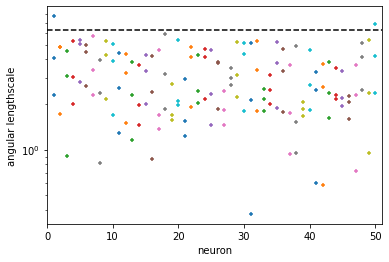

In [27]:
lengthscales = gpr.mapping.kernel.kern1.lengthscale.reshape(neurons, -1).data.cpu().numpy()
C = lengthscales.shape[-1]

fig, ax = plt.subplots()

for n in range(neurons):
    ax.scatter((n + 1)*np.ones(C), lengthscales[n, :], marker='+', s=10)
    
ax.plot([0, neurons+1], [2*np.pi, 2*np.pi], 'k--')
ax.set_xlim([0, neurons+1])
ax.set_yscale('log')

ax.set_ylabel('angular lengthscale')
ax.set_xlabel('neuron')
    
plt.show()

It is also informative to look at the softmax weights and biases that connect the GP functions to the spike count distribution. We now load the pre-softmax weights and biases, with each neuron having its own set of weights and biases. Note we used a exponential-linear expansion for $\phi(\cdot)$. This expansion combines the GP functions with thei exponentiated values, and for the case of $C = 3$ as in the model that we loaded this takes the form 

$$
\phi(\mathbf{f}) = (f_1, f_2, f_3, e^{f_1}, e^{f_2}, e^{f_3})
$$

giving a 6 dimensional expansion vector before the linear-softmax map to the count distribution.

In [28]:
print(gpr.likelihood.mapping_net.weight.shape)  # (neuron, count, phi(f) dimension)
print(gpr.likelihood.mapping_net.bias.shape)  # (neuron, count)

torch.Size([50, 19, 6])
torch.Size([50, 19])


In [29]:
ne = 20  # select neuron
Wn = gpr.likelihood.mapping_net.weight[ne, :, :].data.cpu().numpy()
ne = 20  # select neuron
bn = gpr.likelihood.mapping_net.bias[ne, :].data.cpu().numpy()

Wmax = max(-Wn.min(), Wn.max())

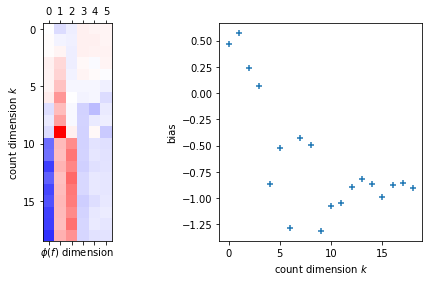

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))


im = axes[0].matshow(Wn, vmin=-Wmax, vmax=Wmax, cmap=weight_map)
axes[0].set_xlabel(r'$\phi(f)$ dimension')
axes[0].set_ylabel(r'count dimension $k$')

axes[1].scatter(np.arange(bn.shape[0]), bn, marker='+', s=30)
axes[1].set_ylabel('bias')
axes[1].set_xlabel(r'count dimension $k$')

    
plt.show()